In [1]:
import numpy as np
from scipy import sparse
import pandas as pd
import xgboost as xgb
import re
import string
import time
import seaborn as sns
import itertools
import lightgbm as lgb
#from bayes_opt import BayesianOptimization
import seaborn as sns
import matplotlib.pyplot as plt

import random
from sklearn import preprocessing, pipeline, metrics, model_selection
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.neural_network import MLPClassifier


%matplotlib inline 


In [2]:
import xgboost
xgboost.__version__

'0.6'

# Define functions for normalized-gini caculation

In [2]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return [('gini', gini_score)]

def gini_lgb(preds, dtrain):
    y = list(dtrain.get_label())
    score = gini(y, preds) / gini(y, y)
    return 'gini', score, True


def gini_s(actual, pred, cmpcol = 0, sortcol = 1):
#     pred=pred[:,1]
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized_s(a, p):
    p=p[:,1]
    return gini_s(a, p) / gini(a, a)



gini_scorer = metrics.make_scorer(gini_normalized_s, greater_is_better=True, needs_proba=True)

def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
##Grid Search for the best model
    model = model_selection.GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = gini_scorer,
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    print("Scores:", model.grid_scores_)
    return model

# Data initialization

In [3]:
train_data = pd.read_csv('/Users/ywu58/Documents/DataScienceLab/Kaggle/train-1.csv')
test_data = pd.read_csv('/Users/ywu58/Documents/DataScienceLab/Kaggle/test-1.csv')
train_size = train_data.shape[0]

## Merge training and testing data
So we don't have to perform transformations twice

In [4]:
full_data=pd.concat([train_data,test_data])

## Group variables

In [5]:
cat_vars = [var for var in full_data.columns if 'cat' in var]

num_vars = [var for var in full_data.columns if 'cat' not in var and var != 'id' and var!='target']

id_var = 'id'
target_var = 'target'

# EDA

## Feature correlation

Let's take a look at feature correlations to target by the subject their name indicate, e.g. Car, Registrant(Car owner), index, calculations

### Registrant

Features for car owners tend to highly correlated to target

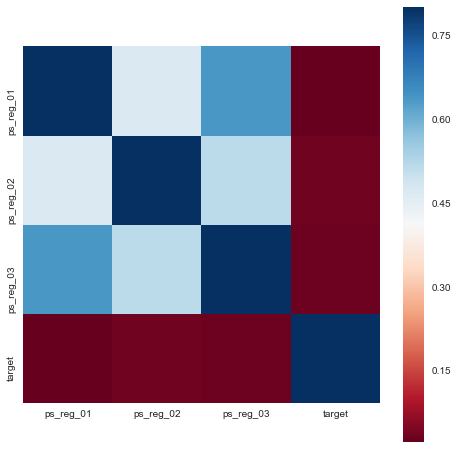

In [6]:
reg_vars = [var for var in full_data.columns if 'reg' in var]
corrmat = train_data[reg_vars+[target_var]].dropna().corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=.8, square=True, cmap='RdBu');

### Car

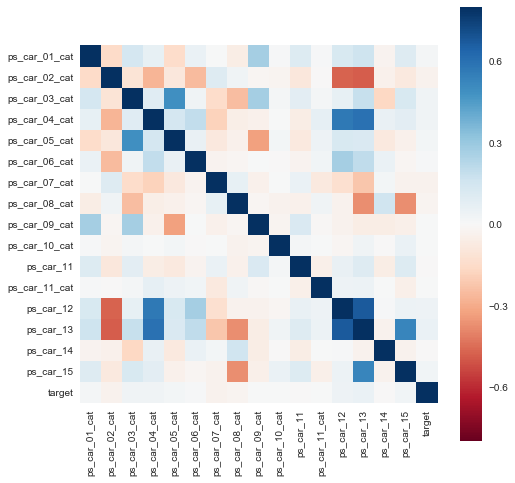

In [7]:
car_vars = [var for var in full_data.columns if 'car' in var]
corrmat = train_data[car_vars+[target_var]].dropna().corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=.8, square=True, cmap='RdBu');

### Index

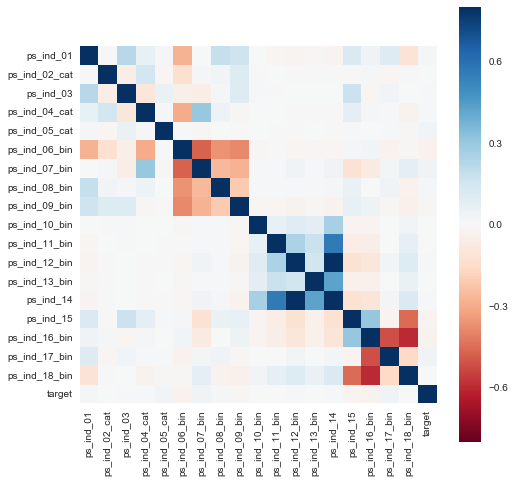

In [8]:
ind_vars = [var for var in full_data.columns if 'ind' in var]
corrmat = train_data[ind_vars+[target_var]].dropna().corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=.8, square=True, cmap='RdBu');

### Calculated features

Calculated feature don't seem to be correcated to target

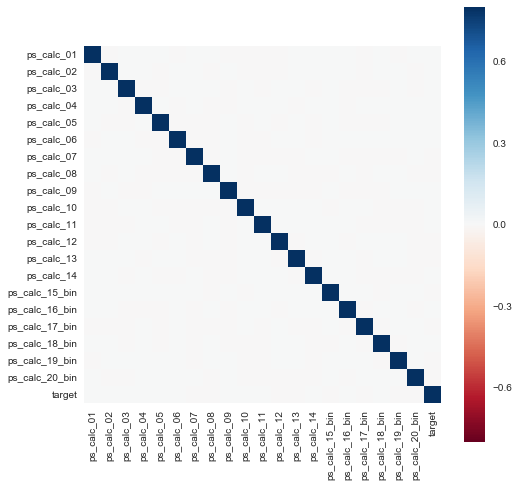

In [9]:
calc_vars = [var for var in full_data.columns if 'calc' in var]
corrmat = train_data[calc_vars+[target_var]].dropna().corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=.8, square=True, cmap='RdBu');

### Overall

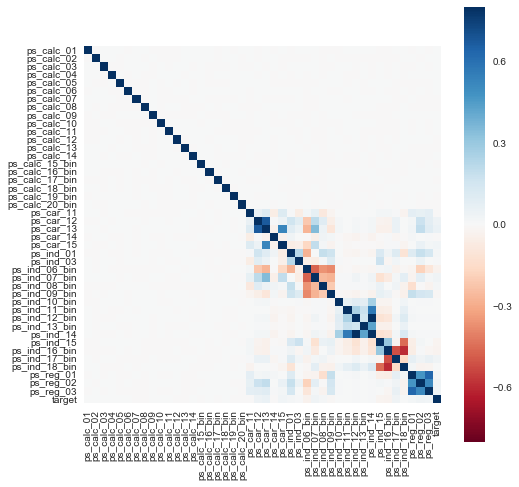

In [10]:
corrmat = train_data[num_vars+[target_var]].dropna().corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=.8, square=True, cmap='RdBu');

### Findings

1. Registrant related features are highly correlated to target
2. Calculated reatures seem to have little to zero correlation to target. Maybe we can remove them from the datasets?

## Distributions

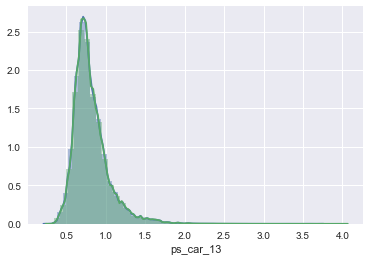

In [11]:
sns.distplot(train_data.ps_car_13)
sns.distplot(test_data.ps_car_13)

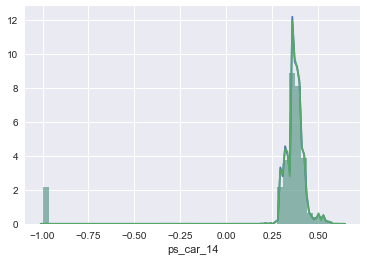

In [12]:
sns.distplot(train_data.ps_car_14)
sns.distplot(test_data.ps_car_14)

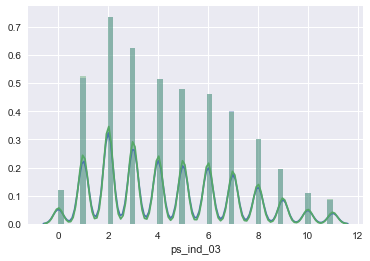

In [13]:
sns.distplot(train_data.ps_ind_03)
sns.distplot(test_data.ps_ind_03)

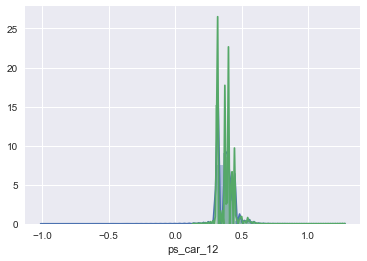

In [14]:
sns.distplot(train_data.ps_car_12)
sns.distplot(test_data.ps_car_12)

# Feature engineering

## Missing value imputation

In this competition, missing values have already been pre-imputed as -1 (see [Data Description](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data)), so technically we don't have to do any imputation to make the data work with most algorithms. 

However, XGBoost and LightGBM have a unique way of dealing with missing values which tend to be effective most of the time. By default, the assume Nan as missing value and would try to create splitting point for those samples with Nan. I would be interesting to try the followings and see which works better:

1. Use the data as is (leave -1 in the data)
2. Convert -1 to Nan, so both XGBoost and LightGBM will automatically deal with missing value

## Pre-processing

### Categorical features - label encoding

Label encoding is not really necessary for this competition as all categorical features have already been digitalized. I'm including this just for your reference.


In [15]:
LBL = preprocessing.LabelEncoder()

LE_vars=[]
LE_map=dict()
for cat_var in cat_vars:
    print ("Label Encoding %s" % (cat_var))
    LE_var=cat_var+'_le'
    full_data[LE_var]=LBL.fit_transform(full_data[cat_var].fillna(-1))
    LE_vars.append(LE_var)
    LE_map[cat_var]=LBL.classes_
    
print ("Label-encoded feaures: %s" % (LE_vars))

Label Encoding ps_car_01_cat
Label Encoding ps_car_02_cat
Label Encoding ps_car_03_cat
Label Encoding ps_car_04_cat
Label Encoding ps_car_05_cat
Label Encoding ps_car_06_cat
Label Encoding ps_car_07_cat
Label Encoding ps_car_08_cat
Label Encoding ps_car_09_cat
Label Encoding ps_car_10_cat
Label Encoding ps_car_11_cat
Label Encoding ps_ind_02_cat
Label Encoding ps_ind_04_cat
Label Encoding ps_ind_05_cat
Label-encoded feaures: ['ps_car_01_cat_le', 'ps_car_02_cat_le', 'ps_car_03_cat_le', 'ps_car_04_cat_le', 'ps_car_05_cat_le', 'ps_car_06_cat_le', 'ps_car_07_cat_le', 'ps_car_08_cat_le', 'ps_car_09_cat_le', 'ps_car_10_cat_le', 'ps_car_11_cat_le', 'ps_ind_02_cat_le', 'ps_ind_04_cat_le', 'ps_ind_05_cat_le']


### Categorical features - one hot encoding¶

You don't want to concatenate the converted OHE features with the original dataframe(full_data) becuase it would exponentially enlarge the size of the dataframe. In fact, it's recommended to use scipy.sparse.hstack to concatenate the data which you will see in the following sections.

In [16]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
OHE.fit(full_data[LE_vars])
OHE_sparse=OHE.transform(full_data[LE_vars])
                                   
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))


OHE_vars = [var[:-3] + '_' + str(level).replace(' ','_')\
                for var in cat_vars for level in LE_map[var] ]

print ("OHE_sparse size :" ,OHE_sparse.shape)
print ("One-hot encoded catgorical feature samples : %s" % (OHE_vars[:100]))

One-hot-encoding finished in 12.075050 seconds
OHE_sparse size : (1488028, 184)
One-hot encoded catgorical feature samples : ['ps_car_01__-1', 'ps_car_01__0', 'ps_car_01__1', 'ps_car_01__2', 'ps_car_01__3', 'ps_car_01__4', 'ps_car_01__5', 'ps_car_01__6', 'ps_car_01__7', 'ps_car_01__8', 'ps_car_01__9', 'ps_car_01__10', 'ps_car_01__11', 'ps_car_02__-1', 'ps_car_02__0', 'ps_car_02__1', 'ps_car_03__-1', 'ps_car_03__0', 'ps_car_03__1', 'ps_car_04__0', 'ps_car_04__1', 'ps_car_04__2', 'ps_car_04__3', 'ps_car_04__4', 'ps_car_04__5', 'ps_car_04__6', 'ps_car_04__7', 'ps_car_04__8', 'ps_car_04__9', 'ps_car_05__-1', 'ps_car_05__0', 'ps_car_05__1', 'ps_car_06__0', 'ps_car_06__1', 'ps_car_06__2', 'ps_car_06__3', 'ps_car_06__4', 'ps_car_06__5', 'ps_car_06__6', 'ps_car_06__7', 'ps_car_06__8', 'ps_car_06__9', 'ps_car_06__10', 'ps_car_06__11', 'ps_car_06__12', 'ps_car_06__13', 'ps_car_06__14', 'ps_car_06__15', 'ps_car_06__16', 'ps_car_06__17', 'ps_car_07__-1', 'ps_car_07__0', 'ps_car_07__1', 'ps_car_08_

## Numeric features

XGBoost/LightGBM which typically don't require pre-processing for numeric features 

# Modelling

We all run XGBoost models using a couple of combinations of features as well as with different missing value settings just to see how differently they perform.


## numerical features + label-encoded categorical features
Let's get started with the simplest combination: **numerical features + label-encoded categorical features** without additional transformations.

In [17]:
full_vars = num_vars + LE_vars
    
train_x = full_data[full_vars].fillna(-1)[:train_size].values
train_y = full_data['target'][:train_size].values
test_x = full_data[full_vars].fillna(-1)[train_size:].values
ids = full_data[train_size:].id.values


train_y = full_data['target'][:train_size].values

print ('train data size:', train_x.shape, 'test data size:', test_x.shape)    

train data size: (595212, 57) test data size: (892816, 57)


#### Tips
It's a good idea of running a cross validation using XGBoost's embedded cv function. This way we can also get the **optimized number of rounds (trees)** needed.

In [18]:
xgb_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'objective': 'binary:logistic',
    'eta': 0.1,
    'seed': 1234}

print(xgb_params)

cv_results = xgb.cv(xgb_params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1)),
                    num_boost_round=1000000,
                    nfold=5,
                    feval=gini_xgb, # custom evaluation metric
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=50,
                    seed=1234,
                    early_stopping_rounds=50)

best_xgb_score = cv_results['test-gini-mean'].max()
best_xgb_iteration = len(cv_results)

print('best score:', best_xgb_score, 'best iterations:', best_xgb_iteration)


{'max_depth': 6, 'min_child_weight': 1, 'subsample': 1, 'colsample_bytree': 1, 'gamma': 0, 'objective': 'binary:logistic', 'eta': 0.1, 'seed': 1234}
[0]	train-error:0.0363986+7.86384e-06	train-gini:0.224332+0.00261274	test-error:0.036503+2.57138e-05	test-gini:0.211238+0.0105772
[50]	train-error:0.036413+1.08995e-05	train-gini:0.346628+0.00192882	test-error:0.036449+5.05964e-06	test-gini:0.270908+0.00765347
[100]	train-error:0.036396+6.69328e-06	train-gini:0.422926+0.0044293	test-error:0.0364492+1.39914e-05	test-gini:0.275406+0.00672179
best score: 0.2766634 best iterations: 80


In [19]:
model = xgb.train(xgb_params, 
                  xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1)),
                  num_boost_round=best_xgb_iteration
                 )

preds = model.predict(xgb.DMatrix(test_x))

sub_df = pd.DataFrame({'id': ids, 'target': preds})
sub_df.to_csv("/Users/ywu58/Documents/DataScienceLab/Kaggle/Porto Week01/output/sub_xgb_num_le.csv", index=False)

### Feature importance

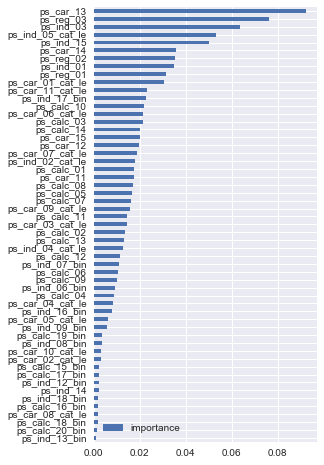

In [20]:
model.feature_names = full_vars
feature_importance = pd.DataFrame.from_dict(model.get_fscore(), orient='index')
feature_importance.columns = ['importance']
feature_importance.importance = feature_importance.importance/ feature_importance.importance.sum()
feature_importance.sort_values(by='importance').plot(kind='barh',figsize=(4,8))

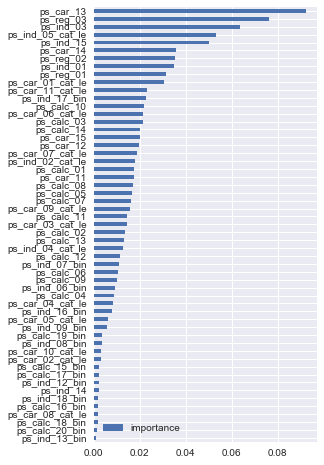

In [21]:
feature_importance.sort_values(by='importance').plot(kind='barh',figsize=(4,8))

### -1 as missing value

As mentioned before, XGBoost has a graceful way of dealing with missing values: you just need to set the parameter "missing", which by default is None but we'll want to set it to -1 for this case.

In [22]:
xgb_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'objective': 'binary:logistic',
    'eta': 0.1,
    'seed': 1234}

print(xgb_params)

cv_results = xgb.cv(xgb_params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                    num_boost_round=1000000,
                    nfold=5,
                    feval=gini_xgb, # custom evaluation metric
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=50,
                    seed=1234,
                    early_stopping_rounds=50)

best_xgb_score = cv_results['test-gini-mean'].max()
best_xgb_iteration = len(cv_results)

print('best score:', best_xgb_score, 'best iterations:', best_xgb_iteration)



{'max_depth': 6, 'min_child_weight': 1, 'subsample': 1, 'colsample_bytree': 1, 'gamma': 0, 'objective': 'binary:logistic', 'eta': 0.1, 'seed': 1234}
[0]	train-error:0.0363986+7.86384e-06	train-gini:0.22424+0.00272183	test-error:0.0365012+1.92499e-05	test-gini:0.211338+0.0103878
[50]	train-error:0.0364132+1.24643e-05	train-gini:0.34732+0.00184722	test-error:0.0364458+1.25124e-05	test-gini:0.270502+0.00692767
[100]	train-error:0.0363946+8.59302e-06	train-gini:0.425116+0.00431678	test-error:0.0364544+8.40476e-06	test-gini:0.275641+0.00579863
best score: 0.2765428 best iterations: 92


In [23]:
model = xgb.train(xgb_params, 
                  xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                  num_boost_round=best_xgb_iteration
                 )

preds = model.predict(xgb.DMatrix(test_x))

sub_df = pd.DataFrame({'id': ids, 'target': preds})
sub_df.to_csv("/Users/ywu58/Documents/DataScienceLab/Kaggle/Porto Week01/output/sub_xgb_num_le_-1_as_missing.csv", index=False)

## numerical features + one-hot-encoded categorical features

In [24]:
full_vars = num_vars    
train_x = full_data[full_vars].fillna(-1)[:train_size].values
train_y = full_data['target'][:train_size].values
test_x = full_data[full_vars].fillna(-1)[train_size:].values
ids = full_data[train_size:].id.values

# concatenate dense features with sparse features
train_x = sparse.hstack([train_x,  
                         OHE_sparse[:train_size]]
                       ).tocsr()

test_x = sparse.hstack([test_x,  
                         OHE_sparse[train_size:]]
                       ).tocsr()

train_y = full_data['target'][:train_size].values

print ('train data size:', train_x.shape, 'test data size:', test_x.shape)    
    

train data size: (595212, 227) test data size: (892816, 227)


In [25]:
xgb_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'objective': 'binary:logistic',
    'eta': 0.1,
    'seed': 1234}

print(xgb_params)

cv_results = xgb.cv(xgb_params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1)),
                    num_boost_round=1000000,
                    nfold=5,
                    feval=gini_xgb, # custom evaluation metric
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=50,
                    seed=1234,
                    early_stopping_rounds=50)

best_xgb_score = cv_results['test-gini-mean'].max()
best_xgb_iteration = len(cv_results)

print('best score:', best_xgb_score, 'best iterations:', best_xgb_iteration)


{'max_depth': 6, 'min_child_weight': 1, 'subsample': 1, 'colsample_bytree': 1, 'gamma': 0, 'objective': 'binary:logistic', 'eta': 0.1, 'seed': 1234}
[0]	train-error:0.0363902+1.43443e-05	train-gini:0.228773+0.00152011	test-error:0.0364994+3.55449e-05	test-gini:0.214088+0.00721422
[50]	train-error:0.0364138+1.37171e-05	train-gini:0.350934+0.00145478	test-error:0.036446+6.51153e-06	test-gini:0.272511+0.00604611
[100]	train-error:0.0364018+9.7857e-06	train-gini:0.424775+0.00153003	test-error:0.0364458+6.91086e-06	test-gini:0.276243+0.0065184
best score: 0.2770308 best iterations: 82


In [26]:
model = xgb.train(xgb_params, 
                  xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1)),
                  num_boost_round=best_xgb_iteration
                 )

preds = model.predict(xgb.DMatrix(test_x))

sub_df = pd.DataFrame({'id': ids, 'target': preds})
sub_df.to_csv("/Users/ywu58/Documents/DataScienceLab/Kaggle/Porto Week01/output/sub_xgb_num_ohe.csv", index=False)

### -1 as missing value

In [27]:
xgb_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'objective': 'binary:logistic',
    'eta': 0.1,
    'seed': 1234}

print(xgb_params)

cv_results = xgb.cv(xgb_params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                    num_boost_round=1000000,
                    nfold=5,
                    feval=gini_xgb, # custom evaluation metric
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=50,
                    seed=1234,
                    early_stopping_rounds=50)

best_xgb_score = cv_results['test-gini-mean'].max()
best_xgb_iteration = len(cv_results)

print('best score:', best_xgb_score, 'best iterations:', best_xgb_iteration)


{'max_depth': 6, 'min_child_weight': 1, 'subsample': 1, 'colsample_bytree': 1, 'gamma': 0, 'objective': 'binary:logistic', 'eta': 0.1, 'seed': 1234}
[0]	train-error:0.0363902+1.43443e-05	train-gini:0.228773+0.00152011	test-error:0.0364994+3.55449e-05	test-gini:0.214088+0.00721422
[50]	train-error:0.0364138+1.37171e-05	train-gini:0.350934+0.00145478	test-error:0.036446+6.51153e-06	test-gini:0.272511+0.00604611
[100]	train-error:0.0364018+9.7857e-06	train-gini:0.424775+0.00153003	test-error:0.0364458+6.91086e-06	test-gini:0.276243+0.0065184
best score: 0.2770308 best iterations: 82


In [28]:
model = xgb.train(xgb_params, 
                  xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                  num_boost_round=best_xgb_iteration
                 )

preds = model.predict(xgb.DMatrix(test_x))

sub_df = pd.DataFrame({'id': ids, 'target': preds})
sub_df.to_csv("/Users/ywu58/Documents/DataScienceLab/Kaggle/Porto Week01/output/sub_xgb_num_ohe_-1_as_missing.csv", index=False)

## Exclude cal features

In [29]:
calc_vars = [var for var in full_data.columns if 'calc' in var]
print (calc_vars)

full_vars = num_vars

for calc_var in calc_vars:
    if calc_var in full_vars:
        full_vars.remove(calc_var)
    
    
train_x = full_data[full_vars].fillna(-1)[:train_size].values
train_y = full_data['target'][:train_size].values
test_x = full_data[full_vars].fillna(-1)[train_size:].values
ids = full_data[train_size:].id.values

# concatenate dense features with sparse features
train_x = sparse.hstack([train_x,  
                         OHE_sparse[:train_size]]
                       ).tocsr()

test_x = sparse.hstack([test_x,  
                         OHE_sparse[train_size:]]
                       ).tocsr()

train_y = full_data['target'][:train_size].values

print ('train data size:', train_x.shape, 'test data size:', test_x.shape)    
    

['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
train data size: (595212, 207) test data size: (892816, 207)


In [30]:
xgb_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'objective': 'binary:logistic',
    'eta': 0.1,
    'seed': 1234}

print(xgb_params)

cv_results = xgb.cv(xgb_params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1)),
                    num_boost_round=1000000,
                    nfold=5,
                    feval=gini_xgb, # custom evaluation metric
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=50,
                    seed=1234,
                    early_stopping_rounds=50)

best_xgb_score = cv_results['test-gini-mean'].max()
best_xgb_iteration = len(cv_results)

print('best score:', best_xgb_score, 'best iterations:', best_xgb_iteration)


{'max_depth': 6, 'min_child_weight': 1, 'subsample': 1, 'colsample_bytree': 1, 'gamma': 0, 'objective': 'binary:logistic', 'eta': 0.1, 'seed': 1234}
[0]	train-error:0.0363982+1.21885e-05	train-gini:0.228838+0.00142976	test-error:0.0365148+4.59321e-05	test-gini:0.21449+0.00697104
[50]	train-error:0.036416+1.22638e-05	train-gini:0.344493+0.000536709	test-error:0.0364476+1.37055e-05	test-gini:0.273932+0.00687845
[100]	train-error:0.0364084+7.73563e-06	train-gini:0.400323+0.00199732	test-error:0.0364494+1.69068e-05	test-gini:0.279155+0.00607628
[150]	train-error:0.0363946+1.14822e-05	train-gini:0.437222+0.00280014	test-error:0.036451+1.35056e-05	test-gini:0.278402+0.00516292
best score: 0.2793324 best iterations: 109


In [31]:
model = xgb.train(xgb_params, 
                  xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1)),
                  num_boost_round=best_xgb_iteration
                 )

preds = model.predict(xgb.DMatrix(test_x))

sub_df = pd.DataFrame({'id': ids, 'target': preds})
sub_df.to_csv("/Users/ywu58/Documents/DataScienceLab/Kaggle/Porto Week01/output/sub_xgb_num_ohe_cal_excluded.csv", index=False)

# Put together

Let's do a quick ensemble by averaging all of the submissions created above

In [32]:
sub_1 = pd.read_csv('/Users/ywu58/Documents/DataScienceLab/Kaggle/Porto Week01/output/sub_xgb_num_le.csv')
sub_2 = pd.read_csv('/Users/ywu58/Documents/DataScienceLab/Kaggle/Porto Week01/output/sub_xgb_num_le_-1_as_missing.csv')
sub_3 = pd.read_csv('/Users/ywu58/Documents/DataScienceLab/Kaggle/Porto Week01/output/sub_xgb_num_ohe.csv')
sub_4 = pd.read_csv('/Users/ywu58/Documents/DataScienceLab/Kaggle/Porto Week01/output/sub_xgb_num_ohe_-1_as_missing.csv')
sub_5 = pd.read_csv('/Users/ywu58/Documents/DataScienceLab/Kaggle/Porto Week01/output/sub_xgb_num_ohe_cal_excluded.csv')

In [33]:
ensemble_preds = (sub_1.target + sub_2.target + sub_3.target + sub_4.target + sub_5.target)/5
sub_df = pd.DataFrame({'id': ids, 'target': ensemble_preds})
sub_df.to_csv("/Users/ywu58/Documents/DataScienceLab/Kaggle/Porto Week01/output/sub_xgb_quick_ensemble.csv", index=False)

# Conclusions

Feature engineering is the key, if not the most important, to the success of a data science projecct including Kaggle competition. It requires a data scientist to have excellent knowledge of Machine Learning algorithms, good sense of business, programming skills and, last but not least, hacker spirits.

In this week's lecture we've learnt how to:

* Preprocess data for
    * Numeric features
    * Categorical features
* Impute missing values
* Select features

# Recommended Kaggle posts:

* [Porto Seguro EDA](https://www.kaggle.com/vmathur/porto-seguro-eda)
* [Steering Wheel of Fortune - Porto Seguro EDA](https://www.kaggle.com/headsortails/steering-wheel-of-fortune-porto-seguro-eda/notebook)
* [Features? We don't need no stinking features!](https://www.kaggle.com/tilii7/features-we-don-t-need-no-stinking-features)
* [Noise analysis of Porto Seguro's features](https://www.kaggle.com/ogrellier/noise-analysis-of-porto-seguro-s-features)


# Additional readings
* [Applied Predictive Modeling - Chapter 3 Data Pre-Processing](http://appliedpredictivemodeling.com/toc/)
* [机器学习特征工程实用技巧大全](https://zhuanlan.zhihu.com/p/26444240)
* [Discover Feature Engineering](http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)
* [Selecting good features – Part IV: stability selection, RFE and everything side by side](http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/)
